<a href="https://colab.research.google.com/github/yyqq-git/mit-15.773/blob/main/HODL_SP24_Lec_05_Music_Genre_Classification_Section_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music Genre Classification

## Introduction


In this notebook we will look at a dataset of song lyrics and will train models that will predict the genre of the song among three possible options: Rock, Pop, and Hip-Hop. This corresponds to a multi-class classification task.

We will cover how to preprocess the text using **standarization** and **tokenization**. Then, we will think on how to represent the words in a way that can be understood by a Deep Learning model. We'll talk about **one-hot encoding**, the **bag-of-words** model and the use of bigrams.



## The TextVectorization Layer

Usual technical preliminaries ...

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

keras.utils.set_random_seed(42)

The STIE process we described in class - Standardize, Tokenize, Index, and Encode - ....

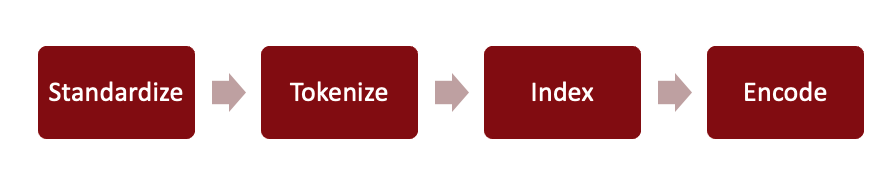

... is implemented by the `TextVectorization` layer.

We first configure the layer by telling it what S, T, I, and E we want.

In our first example,
- we use the default standarization which will remove punctuation and covert to lowercase.
- we use the default tokenization at a word level, by setting `split='whitespace'`.
- we set the output mode to `multi_hot`

In [ ]:
text_vectorization = keras.layers.TextVectorization(
    output_mode = 'multi_hot',
    standardize='lower_and_strip_punctuation',
    split='whitespace'
)

Now that the layer has been configured, we have to run it on a bunch of text to "populate" it.

We use the `adapt()` method for this.



In [ ]:
dataset = [
    "I write, erase, rewrite",
    "Erase again, and then",
    "A poppy blooms.",
    "Hola! are you laid-back in Mexico"
]

In [ ]:
# Index vocabulary of the text
text_vectorization.adapt(dataset)


Once we do that, we can use `get_vocabulary()` to see what exactly has been done.


In [ ]:
# Retrieve the vocabulary
vocabulary = text_vectorization.get_vocabulary()

What's the size of our vocabulary?

In [ ]:
len(vocabulary)

17

In [ ]:
print('Vocabulary:')
print(vocabulary)

Vocabulary:
['[UNK]', 'erase', 'you', 'write', 'then', 'rewrite', 'poppy', 'mexico', 'laidback', 'in', 'i', 'hola', 'blooms', 'are', 'and', 'again', 'a']


**Little programming tip**: If you want to pretty-print a Python object, just make a Pandas dataframe out of it and print the dataframe. It will work only when the object has the same length for all its fields but it is worth a try.

In [ ]:
print('Vocabulary:')
print(pd.DataFrame(vocabulary))

Vocabulary:
           0
0      [UNK]
1      erase
2        you
3      write
4       then
5    rewrite
6      poppy
7     mexico
8   laidback
9         in
10         i
11      hola
12    blooms
13       are
14       and
15     again
16         a



**Note:** Note that the integer 0 is assigned to the `'[UNK]'` "token".  When the model is used for prediction, it may be "fed" a word that's not present in the vocabulary. The `'[UNK]'` token will used to represent such words.

Now that we have configured and populated the `TextVectorization` layer, we can run any sentence through it easily.

In [ ]:
# Encode and decode an example sentence
test_sentence = "I write, rewrite, and still rewrite again"
encoded_sentence = text_vectorization(test_sentence)
print(encoded_sentence)


tf.Tensor([1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0.], shape=(17,), dtype=float32)


It is a 0-1 vector that is as long as our vocabulary (i.e., 17).

Recall that the `'[UNK]'` token is at index 0 and the encoded sentence does have a 1 in that position.

**Why?**

<pre>















</pre>


Because the word "still" was not in our vocab.


In [ ]:
"still" in vocabulary

False

In the spirit of "make small changes to the code to really understand what's going on" ...

What do you think `text_vectorization("Sloan, HODL, DMD")` will be represented as?

<pre>















</pre>


In [ ]:
text_vectorization("Sloan, HODL, DMD")

<tf.Tensor: shape=(17,), dtype=float32, numpy=
array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>

The first index is 1 and all the values are zero! Because none of these words were present in the text we used to populate the layer.


Now that we understand how the vectorization works, we will use the `TextVectorization` layer everytime we want to convert text into readable input for our Deep Learning models.

## Retrieving and preparing the Data



We will work with a dataset that contains the lyrics of almost 90K different songs and its corresponding main genre.

You can find the data in the file `lyric_genre.csv` after downloading it.

Let's inspect it first!


In [ ]:
# Read data from URL

train_df = pd.read_csv('https://www.dropbox.com/s/l583jx2774t6qqd/lyric_genre_train.csv?dl=1', index_col=0).astype(str)
test_df = pd.read_csv('https://www.dropbox.com/s/b7j8lgrehd2ix0d/lyric_genre_test.csv?dl=1', index_col=0).astype(str)
val_df = pd.read_csv('https://www.dropbox.com/s/hb4em4bepnbobev/lyric_genre_val.csv?dl=1', index_col=0).astype(str)

print(f"""
Train samples: {train_df.shape[0]}
Validation samples: {val_df.shape[0]}
Test samples: {test_df.shape[0]}
""")


Train samples: 48991
Validation samples: 16331
Test samples: 21774



In [ ]:
train_df.head()

,Lyric,Genre
0,"Oh, girl. I can't get ready (Can't get ready f...",Pop
1,We met on a rainy evening in the summertime. D...,Pop
2,We carried you in our arms. On Independence Da...,Rock
3,I know he loved you. A long time ago. I ain't ...,Pop
4,Paralysis through analysis. Yellow moral uncle...,Rock


In [ ]:
train_df.tail()

,Lyric,Genre
48986,"[Hook]. Beamer, Benz, Or Bentley. Beamer, Benz...",Hip Hop
48987,You never listen to me. I know I'm better off ...,Pop
48988,Things have come to a pretty pass. Our romance...,Pop
48989,"Little baby, on my shoulder. I could fall into...",Pop
48990,Music : Rudolf Schenker. Lyrics: Klaus Meine. ...,Rock


In [ ]:
# Let's check the proportion of each label in the training set
train_df['Genre'].value_counts() / train_df.shape[0]

Rock       0.549448
Pop        0.295136
Hip Hop    0.155416
Name: Genre, dtype: float64

One thing we need to do before is to convert the `Genre` column into a dummy variable (one-hot encoding). This is because our task will try to predict to which of the 3 categories the song belongs to, and we have to encode this in a way that can be understood by the Neural Network.

In [ ]:
# Let's turn the target into a dummy vector

y_train = pd.get_dummies(train_df['Genre']).to_numpy()
y_val = pd.get_dummies(val_df['Genre']).to_numpy()
y_test = pd.get_dummies(test_df['Genre']).to_numpy()

In [ ]:
y_train

array([[0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1]], dtype=uint8)

Let us build now a model that distinguishes the genre from the lyric!

## Baseline Model (Bag of Words)




We will begin by building the simplest model we could come up with:
- We will tokenize at a word level, and each token will be exactly one word (unigram)
- We will use the one-hot encoding that converts each token into a binary vector indicating the presence of the token. Note that when we tokenize at a word level and use a one-hot encoding to indicate the presence (or as we will see later, the count of the word), the model is called **bag of words**.
- `max_tokens` defines the size of the vocabulary the layer is allowed to construct. If the number of tokens in the `adapt` dataset exceeds this number, the layer will choose the `max_tokens` most frequent tokens and ignore the rest.

In [ ]:
# First, we set up our Text Vectorization layer using multi-hot encoding

max_tokens = 5000
text_vectorization = keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="multi_hot")


Now let's run our STIE process on the training corpus.

In [ ]:
# The vocabulary that will be indexed is given by the text corpus on our train dataset
text_vectorization.adapt(train_df['Lyric'])

Let's look at the 20 most and 20 least common words in our vectorization.

In [ ]:
text_vectorization.get_vocabulary()[:20]

['[UNK]',
 'the',
 'you',
 'i',
 'to',
 'and',
 'a',
 'me',
 'it',
 'my',
 'in',
 'im',
 'on',
 'your',
 'that',
 'of',
 'all',
 'be',
 'is',
 'we']

In [ ]:
text_vectorization.get_vocabulary()[-20:]

['eden',
 'dagger',
 'curve',
 'cheddar',
 'brew',
 'appears',
 'vacant',
 'universal',
 'unholy',
 'terrified',
 'stickin',
 'rumble',
 'rug',
 'pam',
 'os',
 'ooohh',
 'motto',
 'marshall',
 'loyalty',
 'legacy']

In [ ]:
# We vectorize our input
X_train = text_vectorization(train_df['Lyric'])
X_val = text_vectorization(val_df['Lyric'])
X_test = text_vectorization(test_df['Lyric'])

**Question:**

Each phrase is now a vector. How long is this vector?

<pre>








</pre>

Answer: It is `max_tokens` long i.e., 5000.

In [ ]:
X_train

<tf.Tensor: shape=(48991, 5000), dtype=float32, numpy=
array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]], dtype=float32)>

We can think of this matrix as a sequence of row vectors. Each row vector is one of the ~49K songs in our training data, and each entry of this vector indicates the presence of the word that is indexed in that position. For example, the second entry in all the vectors corresponds to the word 'the' and a 1 indicates the presence of that word in the song.

Let's try a simple 1-hidden layer NN with just 8 neurons in the hidden layer.

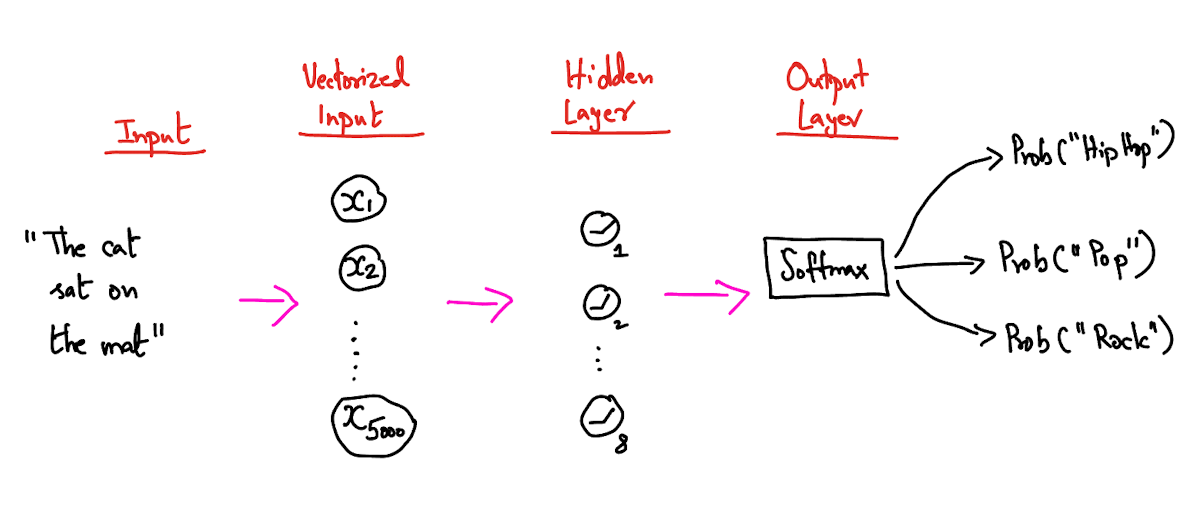

In [ ]:
inputs = keras.Input(shape=(max_tokens, ))
x = keras.layers.Dense(8, activation="relu")(inputs)
outputs = keras.layers.Dense(3, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5000)]            0         
                                                                 
 dense (Dense)               (None, 8)                 40008     
                                                                 
 dense_1 (Dense)             (None, 3)                 27        
                                                                 
Total params: 40035 (156.39 KB)
Trainable params: 40035 (156.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
# Fit model

model.fit(x=X_train, y=y_train,
          validation_data=(X_val, y_val),
          epochs=10,
          batch_size=32)

Epoch 1/10
1531/1531 [==============================] - 6s 3ms/step - loss: 0.6167 - accuracy: 0.7311 - val_loss: 0.5701 - val_accuracy: 0.7529
Epoch 2/10
1531/1531 [==============================] - 5s 3ms/step - loss: 0.5200 - accuracy: 0.7765 - val_loss: 0.5730 - val_accuracy: 0.7497
Epoch 3/10
1531/1531 [==============================] - 5s 3ms/step - loss: 0.4820 - accuracy: 0.7919 - val_loss: 0.5849 - val_accuracy: 0.7434
Epoch 4/10
1531/1531 [==============================] - 5s 3ms/step - loss: 0.4509 - accuracy: 0.8067 - val_loss: 0.6015 - val_accuracy: 0.7415
Epoch 5/10
1531/1531 [==============================] - 5s 3ms/step - loss: 0.4227 - accuracy: 0.8207 - val_loss: 0.6270 - val_accuracy: 0.7407
Epoch 6/10
1531/1531 [==============================] - 5s 3ms/step - loss: 0.3987 - accuracy: 0.8324 - val_loss: 0.6586 - val_accuracy: 0.7382
Epoch 7/10
1531/1531 [==============================] - 5s 3ms/step - loss: 0.3766 - accuracy: 0.8433 - val_loss: 0.6785 - val_accuracy:

In [ ]:
model.evaluate(x=X_test, y=y_test)

681/681 [==============================] - 1s 2ms/step - loss: 0.8323 - accuracy: 0.7203


[0.8323413133621216, 0.7202627062797546]

Note that the largest class is Rock, with around 58%, so a dummy predictor that outputs the most common class would get 58% accuracy.

Our simple 1-hidden layer NN using multi-hot encoding improves on that nicely!!


## Adding Context with Bigrams



Can we do better? Is there any aspect of the text that we're failing to capture with what we have done so far?

Suppose we're trying to predict the sentiment of a movie review that looks something like this (Note: I can't find the source of this review).

"Kate Winslet's performance as a detective trying to solve a terrible crime in a small Pennsylvania town is anything but disappointing."

A model looking at each word *separately* will get misled by the words "terrible" and "disappointing" since they have a negative sentiment if looked in isolation.

However, by looking at the words near them ("terrible crime", "anything but disappointing"), you can see that it is actually a positive review.

"Nearby" words can thus provide valuable context. And this is useful even for single, atomic concepts that happen to be described using multiple words e.g., United States.

So, how can we make our models more aware of "nearby" words?

We can try **bigrams**, which  use *two consecutive* words as the level of tokenization.

For example, the sentence "the cat sat on the mat" becomes:

Using single words:
`{"cat", "mat", "on", "sat", "the"}`

With bigrams: `{"the", "the cat", "cat", "cat sat", "sat",
 "sat on", "on", "on the", "the mat", "mat"}`

We don't have to stop with bigrams. We can go to trigrams or higher.


Let's warm up with a simple example.

In [ ]:
# Text Vectorization layer using bigrams
text_vectorization = keras.layers.TextVectorization(
    ngrams=2,
    output_mode="multi_hot")

In [ ]:
text_vectorization.adapt(["the cat sat on the mat."])

In [ ]:
text_vectorization.get_vocabulary()

['[UNK]',
 'the',
 'the mat',
 'the cat',
 'sat on',
 'sat',
 'on the',
 'on',
 'mat',
 'cat sat',
 'cat']

See how bigrams are generated? Now back to the original problem.

In [ ]:
# Text Vectorization layer using bigrams

text_vectorization = keras.layers.TextVectorization(
    ngrams=2,
    max_tokens=20000,  #note that we are increasing this from 5000 to accommodate bigrams
    output_mode="multi_hot",
)

In [ ]:
# We run the STIE process on the training corpus
text_vectorization.adapt(train_df['Lyric'])

Let's see what the first and last 10 items in the vocabulary are.

In [ ]:
text_vectorization.get_vocabulary()[:10]

['[UNK]', 'the', 'you', 'i', 'to', 'and', 'a', 'me', 'it', 'my']

In [ ]:
text_vectorization.get_vocabulary()[-10:]

['8x',
 '44',
 'you’re a',
 'your mom',
 'your god',
 'you shot',
 'you hell',
 'you far',
 'ya all',
 'x6']

In [ ]:
X_train = text_vectorization(train_df['Lyric'])
X_val = text_vectorization(val_df['Lyric'])
X_test = text_vectorization(test_df['Lyric'])

In [ ]:
inputs = keras.Input(shape=(20000,))
x = keras.layers.Dense(8, activation="relu")(inputs)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(3, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_2 (Dense)             (None, 8)                 160008    
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 3)                 27        
                                                                 
Total params: 160035 (625.14 KB)
Trainable params: 160035 (625.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Quick sidebar: **Dropout**

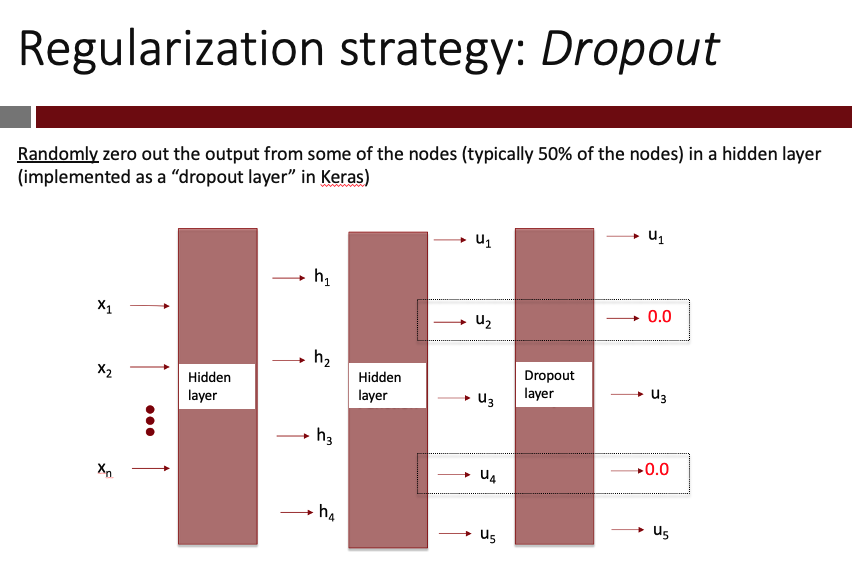

In [ ]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
# Fit model
model.fit(x=X_train, y=y_train,
          validation_data=(X_val, y_val),
          epochs=3,
          batch_size=32)

Epoch 1/3
1531/1531 [==============================] - 8s 4ms/step - loss: 0.7461 - accuracy: 0.6556 - val_loss: 0.5948 - val_accuracy: 0.7413
Epoch 2/3
1531/1531 [==============================] - 6s 4ms/step - loss: 0.6328 - accuracy: 0.7154 - val_loss: 0.5728 - val_accuracy: 0.7565
Epoch 3/3
1531/1531 [==============================] - 6s 4ms/step - loss: 0.5830 - accuracy: 0.7388 - val_loss: 0.5715 - val_accuracy: 0.7551


In [ ]:
model.evaluate(x=X_test, y=y_test)

681/681 [==============================] - 2s 3ms/step - loss: 0.5784 - accuracy: 0.7509


[0.5783977508544922, 0.7508955597877502]

**Our test accuracy increased significantly with just 3 epochs!!**

This improvement highlights the importance of local word order.


Let's run the model on a lyric fragment and see what it predicts. We will create a little helper function to make life easier.

In [ ]:
def lyric_predict(phrase):
    vect_data = text_vectorization([phrase])
    predictions = model.predict(vect_data)
    predictions
    print(f"{float(predictions[0,0] * 100):.2f} % Hip-Hop")
    print(f"{float(predictions[0,1] * 100):.2f} % Pop")
    print(f"{float(predictions[0,2] * 100):.2f} % Rock")

In [ ]:
phrase = """
You can dance, you can jive, having the time of your life
See that girl, watch that scene, diggin' the dancing queen
Friday night and the lights are low,
Looking out for the place to go,
Where they play the right music, getting in the swing.
You come in to look for a king.
Anybody could be that guy,
Night is young and the music's high.
With a bit of rock music, everything is fine,
You're in the mood for a dance.
And when you get the chance...
Chorus:
You are the dancing queen, young and sweet, only seventeen.
Dancing queen, feel the beat from the tambourine.
You can dance, you can jive, having the time of your life.
See that girl, watch that scene, diggin' the dancing queen.
You're a teaser, you turn 'em on,
Leave them burning and then you're gone.
Looking out for another, anyone will do,
You're in the mood for a dance.
And when you get the chance...
"""

In [ ]:
lyric_predict(phrase)

1/1 [==============================] - 0s 18ms/step
1.08 % Hip-Hop
53.00 % Pop
45.92 % Rock


## Conclusions



- We studied a genre clasification task.
- We learned different ways of how to represent text as numerical vectors that can be fed to a neural network structure.
- We saw how adding context to the word representation via bigrams can increase the accuracy of our models.